In [1]:
from typing import List, Union

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D

from statsmodels.stats.proportion import proportion_confint, confint_proportions_2indep
from scipy.stats import t

plt.style.use('ggplot')

In [2]:
if os.path.exists('src'):
    %load_ext autoreload
    %autoreload 2

    from src.statutils import Sp
    from src.utils import add_CI
else:
    !pip install toleranceinterval
    !git clone https://github.com/P-Mihail/medstats_ex.git

    from medstats_ex.src.statutils import Sp  # type: ignore
    from medstats_ex.src.utils import add_CI  # type: ignore

import toleranceinterval as ti

### Глава 7
#### Доверительные интервалы

##### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ РАЗНОСТИ СРЕДНИХ

$(\overline{X}_1-\overline{X}_2)-t_{\alpha}S_{\overline{X}_1-\overline{X}_2} < \mu_1-\mu_2 < (\overline{X}_1-\overline{X}_2)+t_{\alpha}S_{\overline{X}_1-\overline{X}_2}$, 

$S_{\overline{X}_1-\overline{X}_2}=S\sqrt{\cfrac{1}{n_1}+\cfrac{1}{n_2}}$ - стандартная ошибка разности средних, 

$S^2=\cfrac{(n_1-1)s^2_1+(n_2-1)s^2_2}{n_1+n_2-2}$ - объединенная оценка дисперсии.

Этот способ определения доверительного интервала, как и критерий Стыодента, на котором он основан, можно применять только тогда, когда совокупность имеет хотя бы приближенно нормальное распределение.

##### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО

$\overline{X}-t_{\alpha}S_{\overline{X}} < \mu < \overline{X}+t_{\alpha}S_{\overline{X}}$

где $S_{\overline{X}}$ - стандартная ошибка среднего.

##### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ РАЗНОСТИ ДОЛЕЙ

$(\hat{p}_1-\hat{p}_2)-z_{\alpha}S_{\hat{p}_1-\hat{p}_2} < p_1 - p_2 < (\hat{p}_1-\hat{p}_2)+z_{\alpha}S_{\hat{p}_1-\hat{p}_2}$,

$p_1$ и $p_2$ - истинные доли в каждой из совокупностей, $\hat{p}_1=\cfrac{m_1}{n_1}$ и $\hat{p}_2=\cfrac{m_2}{n_2}$ - выборочные оценки этих долей,

$S_{\hat{p}_1-\hat{p}_2} = \sqrt{\hat{p}(1-\hat{p})(\cfrac{1}{n_1} + \cfrac{1}{n_2})}$ - стандартная ошибка разности выборочных долей,

$\hat{p}=\cfrac{m_1 + m_2}{n_1 + n_2}$ - объединенная оценка доли.

##### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ДОЛИ

$\hat{p}-z_{\alpha}S_{\hat{p}}<p<\hat{p}+z_{\alpha}S_{\hat{p}}$,

$S_{\hat{p}}=\sqrt{\cfrac{p(1-p)}{n}}$ - стандартная ошибка доли

!!! необходимо, чтобы $np$ и $n(1 – p)$ были больше 5, иначе вместо нормального распределения придется использовать биномиальное.

##### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ЗНАЧЕНИЙ (Tolerance interval, Толерантный интервал)

Обычно доверительный интервал значений определяют как выборочное среднее плюс-минус два стандартных отклонения. Это хорошо при большом (100+) объеме выборки. 

По выборкам небольшого объема, нужно брать интервал, более широкий, чем плюс-минус два стандартных отклонения (при выборках большого объема такая страховка не нужна). Этот интервал вычисляют по формуле:

$\overline{X}-K_{\alpha}S < X < \overline{X}+K_{\alpha}S$, где $K_{\alpha}$ - коэффициент, который зависит от доли $f$ членов совокупности, которые должны попасть в доверительный
интервал, от вероятности того, что они действительно туда попали $1 – \alpha$ и от объема выборки $n$. Этот коэффициент играет примерно ту же роль, что $t_{\alpha}$ или $Z_{\alpha}$. (K > t > Z,  поскольку K учитывает не только значение среднего, но и неопределенность оценок среднего и стандартного отклонения).

Для нахождения К можно применить специальные диаграммы или воспользоваться сразу пакетом toleranceinterval позволяющим найти интервал толерантности.

**7.1.**
По данным из задачи 2.6 найдите 90 и 95% доверительные интервалы для среднего числа авторов статей, опубликованных в медицинских журналах за 1946, 1956, 1966 и 1976 гг.
> **2.6**
> Р. Флетчер и С. Флетчер (R. Fletcher, S. Fletcher. Clinical research in general medical journals: a 30-year perspective. N. Engl. J. Med., 301:180–183, 1979) изучили библиографические характеристики 612 случайно выбранных статей, опубликованных в журналах Journal of American Medical Association, New England Journal of Medicine и Lancet с 1946 г. Одним из показателей было число авторов статьи. Было установлено следующее:

|Год|Число обследованных статей|Среднее число авторов|Стандартное отклонение|
|-|-|-|-|
|1946|151|2,0|1,4|
|1956|149|2,3|1,6|
|1966|157|2,8|1,2|
|1976|155|4,9|7,3|

> Нарисуйте график среднего числа авторов по годам. Может ли распределение статей по числу авторов быть нормальным?
> Почему?

In [3]:
df = pd.DataFrame(
        [[1946, 151, 2, 1.4], 
        [1956, 149, 2.3, 1.6], 
        [1966, 157, 2.8, 1.2],  
        [1976, 155, 4.9, 7.3]], 
        columns=["year", "n_articles", "mean_authors", "std"])\
    .set_index("year")

df = df.pipe(add_CI, 90, ["n_articles", "mean_authors", "std"]).pipe(add_CI, 95, ["n_articles", "mean_authors", "std"])

display(df)

,n_articles,mean_authors,std,MoE_90,90% LB,90% RB,MoE_95,95% LB,95% RB
year,,,,,,,,,
1946,151,2.0,1.4,0.188563,1.811437,2.188563,0.225116,1.774884,2.225116
1956,149,2.3,1.6,0.216961,2.083039,2.516961,0.259024,2.040976,2.559024
1966,157,2.8,1.2,0.158469,2.641531,2.958469,0.189174,2.610826,2.989174
1976,155,4.9,7.3,0.970297,3.929703,5.870297,1.158328,3.741672,6.058328


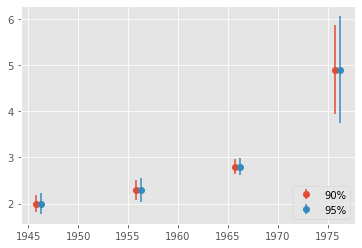

In [4]:
fig, ax = plt.subplots()

for i, p in enumerate([90, 95]):
    ax.errorbar(x=df.index, 
                y=df["mean_authors"], 
                yerr=df[f"MoE_{p}"], 
                fmt="o", 
                transform=Affine2D().translate(-0.25 + i*0.5, 0.0) + ax.transData,
                label=f"{p}%")

plt.legend(loc='lower right')

In [5]:
for p in [90, 95]:
    print(f"{p}% доверительные интервалы:")
    for idx, x in df.iterrows():
        print(f"\t{idx}: {x['mean_authors']} \u00b1 {x[f'MoE_{p}']:.3f} ({x[f'{p}% LB']:.3f}, {x[f'{p}% RB']:.3f})")

90% доверительные интервалы:
	1946: 2.0 ± 0.189 (1.811, 2.189)
	1956: 2.3 ± 0.217 (2.083, 2.517)
	1966: 2.8 ± 0.158 (2.642, 2.958)
	1976: 4.9 ± 0.970 (3.930, 5.870)
95% доверительные интервалы:
	1946: 2.0 ± 0.225 (1.775, 2.225)
	1956: 2.3 ± 0.259 (2.041, 2.559)
	1966: 2.8 ± 0.189 (2.611, 2.989)
	1976: 4.9 ± 1.158 (3.742, 6.058)


**7.2.**
Ранее (задача 3.1) мы познакомились с исследованием Ч. О’Херлихи и Г. Мак-Дональда (С. O’Herlihy, H. MacDonald. Influence of preinduction prostaglandin E2 vaginal gel on cervical
ripening and labor. Obstet. Gynecol., 54:708—710, 1979). Как выяснилось, гель с простагландином Е2 сокращает продолжительность родов. Позволяет ли он избежать кесарева сечения? В группе, получавшей гель с простагландином Е2, кесарево сечение потребовалось 15% женщин, в контрольной группе — 23,9%. В обеих группах было по 21 женщине. Найдите 95% доверительные интервалы для доли рожениц, которым требуется кесарево сечение в обеих группах. Найдите 95% доверительный интервал для разности долей. Можно ли утверждать, что простагландин снижает вероятность кесарева сечения?
> **3.1** Если  при  родах  шейка  матки  долго  не  раскрывается, то продолжительность родов увеличивается и может возникнуть необходимость кесарева сечения. Ч. О’Херлихи и Г. Мак-Дональд (С. O’Herlihy, H. MacDonaid. Influence of reproduction prostaglandin E2 vaginal gel on cervical ripening and labor. Obstet. Gynесоl., 54: 708—710, 1979) решили выяснить, ускоряет ли гель с простагландином Е2 раскрытие шейки матки. В исследование вошло 2 группы  рожениц.  Роженицам  первой  группы  вводили  в  шейку матки гель с простагландином Е2, роженицам второй группы вводили гель-плацебо. В обеих группах было по 21 роженице возраст, рост и сроки беременности были примерно одинаковы. Роды в группе, получавшей гель с простагландином Е2, длились в среднем 8,5 ч (стандартное отклонение 4,7 ч), в контрольной группе — 13,9 ч (стандартное отклонение — 4,1 ч). Можно ли утверждать, что гель с простагландином Е2 сокращал продолжительность родов?

In [6]:
N = 21

df = pd.DataFrame(
    data=[[0.15, 0.85], [0.239, 0.761]], 
    index=["Treatment group", "Control group"], 
    columns=["+ C-section", "- C-section"]
)

# df["SE"] = (df["+ C-section"]*df["- C-section"]/21)**.5
df["m"] = (df["+ C-section"]*N).round().astype("int")
df["n"] = N

df[["CI L", "CI R"]] = df.apply(lambda r: proportion_confint(count=r["m"], nobs=r["n"], alpha=0.05, method='beta'), 1, result_type ='expand')

display(df)

,+ C-section,- C-section,m,n,CI L,CI R
Treatment group,0.150,0.850,3,21,0.030489,0.363424
Control group,0.239,0.761,5,21,0.082176,0.471660


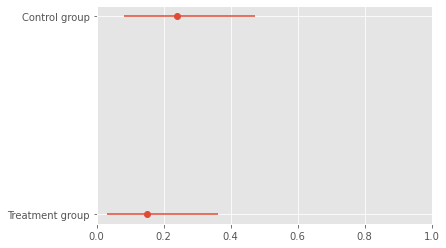

In [7]:
fig, ax = plt.subplots()

ax.errorbar(x=df["+ C-section"],
            y=df.index,
            xerr=(df["+ C-section"] - df["CI L"], df["CI R"] - df["+ C-section"]),
            fmt="o")

plt.xlim([0, 1]);

In [8]:
confint_proportions_2indep(5, 21, 3, 21, method="wald")

(-0.14052267847608735, 0.3309988689522778)

**Ответ:**

для контрольной группы CI = 8-47%, для группы, получавшей гель с простагландином Е2 CI = 3-36%. 

95% доверительный интервал для разности долей: (-14%, 33%). Т.о. разность долей статистически не значима.

**7.3.**

По данным задачи 3.1 найдите 95% доверительный интервал для разности средней продолжительности родов у получавших гель с простагландином Е2 и получавших плацебо. Позволяет ли вычисленный доверительный интервал утверждать, что различия статистически значимы?

In [9]:
N = 21

df = pd.DataFrame(
    data=[[8.5, 4.7], [13.9, 4.1]], 
    index=["Treatment group", "Control group"], 
    columns=["mean", "std"]
)

# df["MoE_95%"] = t.ppf(.975, df=20, scale=df["std"]/21**.5)

display(df)

,mean,std
Treatment group,8.5,4.7
Control group,13.9,4.1


In [10]:
MoE = t.ppf(0.975, 40) * Sp(21, 21, 4.7, 4.1) * (2/21)**.5

13.9 - 8.5 - MoE, 13.9 - 8.5 + MoE

(2.6492718896724883, 8.150728110327513)

**Ответ:**
95% доверительный интервал разности средней продолжительности родов — от 2,65 до 8,15. Различия статистически значимы (Р < 0,05).

**7.4.**
По данным задачи 5.1 найдите 95% доверительные интервалыдля долей больных, которые не чувствовали боли при включенном и выключенном приборе. Можно ли по этим интервалам оценить статистическую значимость различий?
> **5.1.** Т. Бишоп (Т. Bishop. High frequency neural modulation in dentistry. J. Am. Dent. Assoc., 112:176—177, 1986) изучил эффективность высокочастотной стимуляции нерва в качестве обезболивающего средства при удалении зуба. Все больные подключались к прибору, но в одних случаях он работал, в других был выключен. Ни стоматолог, ни больной не знали, включен ли прибор. Позволяют ли следующие данные считать высокочастотную стимуляцию нерва действенным анальгезируюшим средством?

-|Прибор включен|Прибор выключен
-|-|-
Боли нет|24|3
Боль есть|6|17

In [11]:
df = pd.DataFrame(data=[[24, 6], [3, 17]], 
                  columns=["Боли нет", "Боль есть"], 
                  index=["Прибор включен", "Прибор выключен"])

display(df)

,Боли нет,Боль есть
Прибор включен,24,6
Прибор выключен,3,17


In [12]:
for idx, row in df.iterrows():
    print(f"{idx}:{row.sum()}")
    print(f"\tp = {row['Боли нет']/row.sum()*100:.2f}")
    ci = proportion_confint(count=row['Боли нет'], nobs=row.sum(), alpha=0.05, method='beta')
    print(f"\tДоверительный интервал: ({ci[0]*100:.2f}%, {ci[1]*100:.2f}%)")

Прибор включен:30
	p = 80.00
	Доверительный интервал: (61.43%, 92.29%)
Прибор выключен:20
	p = 15.00
	Доверительный интервал: (3.21%, 37.89%)


Доверительные интервалы не перекрываются, поэтому различия статистически значимы.

**7.5.**
Поданным задачи 3.2 найдите 95% доверительные интервалы для каждой из групп. В чем заключаются различия между группами?
> **3.2** Курение считают основным фактором, предрасполагающим  к  хроническим  обструктивным  заболеваниям  легких.  Что касается пассивного курения, оно таким фактором обычно не считается. Дж. Уайт  и Г. Фреб усомнились в безвредности пассивного курения и исследовали проходимость дыхательных путей у некурящих,  пассивных  и  активных  курильщиков  (J.  White,  H. Froeb. Small-airways dysfunction in nonsmokers chronically exposed to tobacco smoke. N. Engl. J. Med., 302:720—723, 1980). Для характеристики состояния дыхательных путей взяли один из показателей функции внешнего дыхания — аксимальную объемную скорость середины выдоха которую измеряли во время профилактического  осмотра  сотрудников  Калифорнийского  университета в Сан-Диего. Уменьшение этого показателя — признак нарушения проходимости дыхательных путей. Данные обследования представлены в таблице. Размер каждой группы - 200 человек. <br>
> **Максимальная объемная скорость средины выдоха, л/с**

Группа|Среднее|Стандартное отклонение
-|-|-
Некурящие работающие в помещении, где не курят | 3,17 | 0,74
Некурящие работающие в накуренном помещении | 2,72 | 0,71
Курящие выкуривающие небольшое число сигарет | 2,63 | 0,73
Курящие выкуривающие среднее число сигарет | 2,29 | 0,70
Курящие выкуривающие большое число сигарет | 2,12 | 0,72

> Можно  ли считать максимальную объемную скорость середины выдоха одинаковой во всех группах?

In [13]:
N = 200

df = pd.DataFrame(
    data=[[3.17, 0.74],[2.72, 0.71],[2.63, 0.73],[2.29, 0.70],[2.12, 0.72]], 
    index=pd.MultiIndex.from_tuples([
        ("Некурящие", "работающие в помещении, где не курят"), 
        ("Некурящие", "работающие в накуренном помещении"), 
        ("Курящие", "выкуривающие небольшое число сигарет"), 
        ("Курящие", "выкуривающие среднее число сигарет"), 
        ("Курящие", "выкуривающие большое число сигарет")
        ]), 
    columns=["mean", "std"]
)

df = df.pipe(add_CI, 95, [200, "mean", "std"])

display(df)

mean   std    MoE_95  \
Некурящие работающие в помещении, где не курят  3.17  0.74  0.103184   
          работающие в накуренном помещении     2.72  0.71  0.099001   
Курящие   выкуривающие небольшое число сигарет  2.63  0.73  0.101790   
          выкуривающие среднее число сигарет    2.29  0.70  0.097607   
          выкуривающие большое число сигарет    2.12  0.72  0.100396   

                                                  95% LB    95% RB  
Некурящие работающие в помещении, где не курят  3.066816  3.273184  
          работающие в накуренном помещении     2.620999  2.819001  
Курящие   выкуривающие небольшое число сигарет  2.528210  2.731790  
          выкуривающие среднее число сигарет    2.192393  2.387607  
          выкуривающие большое число сигарет    2.019604  2.220396

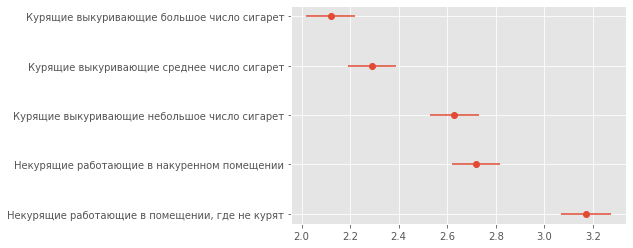

In [14]:
fig, ax = plt.subplots()

ax.errorbar(x=df["mean"], 
            y=[' '.join(col) for col in df.index], 
            xerr=df[f"MoE_95"], 
            fmt="o");

In [15]:
print("95% доверительные интервалы:")
for idx, x in df.iterrows():
    print(f"\t{''.join(idx)}: {x['mean']} \u00b1 {x[f'MoE_95']:.3f} ({x[f'95% LB']:.3f}, {x[f'95% RB']:.3f})")

95% доверительные интервалы:
	Некурящиеработающие в помещении, где не курят: 3.17 ± 0.103 (3.067, 3.273)
	Некурящиеработающие в накуренном помещении: 2.72 ± 0.099 (2.621, 2.819)
	Курящиевыкуривающие небольшое число сигарет: 2.63 ± 0.102 (2.528, 2.732)
	Курящиевыкуривающие среднее число сигарет: 2.29 ± 0.098 (2.192, 2.388)
	Курящиевыкуривающие большое число сигарет: 2.12 ± 0.100 (2.020, 2.220)


Объединив группы с перекрывающимися доверительными интервалами, получим 3 категории: 
1. некурящие, работающие в помещении, где не курят
2. пассивные курильщики и выкуривающие небольшое число сигарет
3. выкуривающие среднее и большое число сигарет


**7.6.**

По данным задачи 5.6 найдите 95% доверительные интервалы для доли работ, где данные были получены до планирования исследования.

> **5.6**

> Как правило, качество исследования выше, а соответствие собираемых данных поставленному вопросу точнее, если данные собираются специально для этого исследования после его планирования. Р. и С. Флетчеры (R. Fletcher, S. Fletcher. Clinical research in general medical journals: а 30-year perspective. N. Engl. J. Med., 301:180—183, 1979) исследовали 612 работ, случайным образом выбранных из журналов Journal of American Medical Association, Lancet и New England Journal of Medicine, чтобы определить, собирали ли их авторы свои данные до или после планирования исследования. Вот что удалось обнаружить:

_|1946|1956|1966|1976
-|-|-|-|-
Число рассмотренных работ|151|149|157|155
Процент работ, где данные собирали после планирования исследования|76|71|49|44
Процент работ, где данные собирали до планирования исследования|24|29|51|56


> Оцените статистическую значимость различия долей. Если различия есть, то можно ли сказать, что положение меняется к лучшему?


In [16]:
df = pd.DataFrame(data=[[151, 24], [149, 29], [157, 51], [155, 56]], 
                  columns=["N", "P"],
                  index=[1946, 1956, 1966, 1976])


df[["95% LB", "95% RB"]] = df.apply(lambda row: [100*x for x in proportion_confint(count=int(row["N"]*row["P"]/100), 
                                                                                   nobs=row["N"], alpha=0.05, method='beta')],
                                    axis=1,
                                    result_type='expand')

display(df)

,N,P,95% LB,95% RB
1946,151,24,17.290802,31.446672
1956,149,29,21.737383,36.842380
1966,157,51,42.864679,59.009409
1976,155,56,47.296879,63.457161


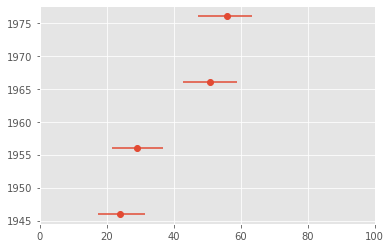

In [17]:
fig, ax = plt.subplots()

ax.errorbar(x=df["P"],
            y=df.index,
            xerr=(df["P"] - df["95% LB"], df["95% RB"] - df["P"]),
            fmt="o")

plt.xlim([0, 100]);

In [18]:
print("95% доверительные интервалы:")
for idx, row in df.iterrows():
    print(f"\t {idx} - ({row['95% LB']:.2f}%; {row['95% RB']:.2f}%)")

95% доверительные интервалы:
	 1946 - (17.29%; 31.45%)
	 1956 - (21.74%; 36.84%)
	 1966 - (42.86%; 59.01%)
	 1976 - (47.30%; 63.46%)


**7.7.**

По данным задачи 2.2 найдите 95% доверительные интервалы для 90 и 95% значений. Результаты представьте на одном рисунке с исходными данными.

> Найдите среднее, стандартное отклонение, медиану, 25-й и 75-й процентили для следующих данных 289, 203, 359, 243, 232,  210,  251,  246,  224,  239,  220,  211.  Можно  ли  считать,  что выборка извлечена из совокупности с нормальным распределением? Обоснуйте свой ответ. (Эти числа — продолжительность (в секундах) физической нагрузки до развития приступа стенокардии у 12 человек с ишемической болезнью сердца. Данные заимствованы  из работы: W. Aronow. Effect of nonnicotine cigaretts and carbon monoxide on angina. Circulation, 61:262–265, 1979. Более подробно эта работа описана в задаче 9.5.)

In [19]:
inp = np.array([289, 203, 359, 243, 232,  210,  251,  246,  224,  239,  220,  211])

ti90 = ti.twoside.normal(inp, 0.9, 0.95)
ti95 = ti.twoside.normal(inp, 0.95, 0.95)

print(f"90% толерантный интервал: {int(ti90[0][0])} - {int(ti90[0][1])}")
print(f"95% толерантный интервал: {int(ti95[0][0])} - {int(ti95[0][1])}")

90% толерантный интервал: 128 - 358
95% толерантный интервал: 107 - 380


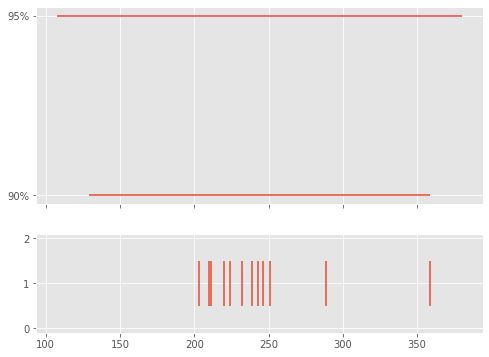

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [2, 1]}, sharex=True)

axs[0].hlines("90%", ti90[0][0], ti90[0][1])
axs[0].hlines("95%", ti95[0][0], ti95[0][1])

axs[1].eventplot(inp);